<a href="https://colab.research.google.com/github/szandian/Computer_Vision/blob/main/HW3_szandian_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Q1 – Data Pipeline, Visualization & Augmentation**

1.1 Load a Small Open‐Source Object Detection Dataset

Dataset Choice: For example, you can use a small split from Pascal VOC (e.g., VOC2007) or a “tiny” version of COCO from TensorFlow Datasets.


In [ ]:
import torchvision
import torchvision.transforms as T
from torchvision.datasets import VOCDetection
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# Define a transform to convert PIL images to tensor (and later to numpy for plotting)
transform = T.Compose([T.ToTensor()])

# Load a small subset (e.g., only a few samples) from VOC2007 for demonstration
dataset = VOCDetection(root='./VOC2007', year='2007', image_set='train', download=True, transform=None)






100%|██████████| 460M/460M [00:13<00:00, 35.3MB/s]


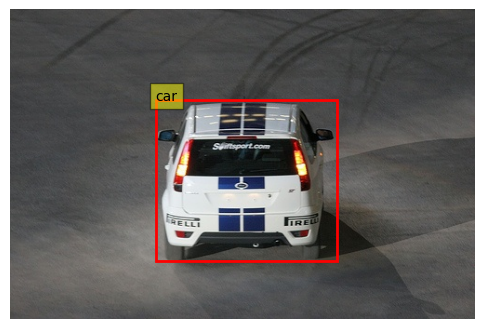

In [ ]:
# Display a sample image with ground-truth bounding boxes:
def plot_voc_sample(idx):
    img, target = dataset[idx]
    boxes = []
    labels = []
    objects = target['annotation']['object']
    if not isinstance(objects, list):
        objects = [objects]
    for obj in objects:
        bndbox = obj['bndbox']
        box = [int(bndbox['xmin']), int(bndbox['ymin']),
               int(bndbox['xmax']), int(bndbox['ymax'])]
        boxes.append(box)
        labels.append(obj['name'])

    # Convert PIL image to a NumPy array
    npimg = np.array(img)
    plt.figure(figsize=(6,6))
    plt.imshow(npimg)
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                          fill=False, edgecolor='red', linewidth=2))
        plt.text(xmin, ymin, label, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_voc_sample(0)

1.2 Create a Data Pipeline

Train/Validation Split: For example, use an 80/20 split.

Example:

In [ ]:
from torch.utils.data import random_split, DataLoader

# Determine split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


1.3 Visualize Bounding Boxes

Pick 3–5 random training images and overlay boxes:

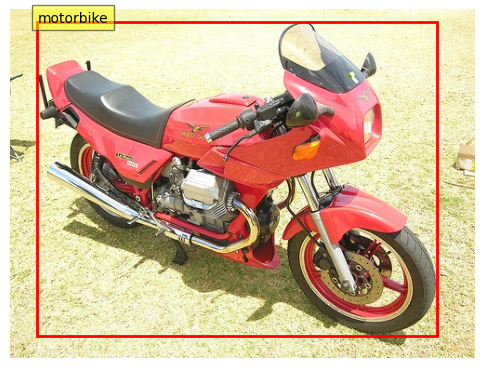

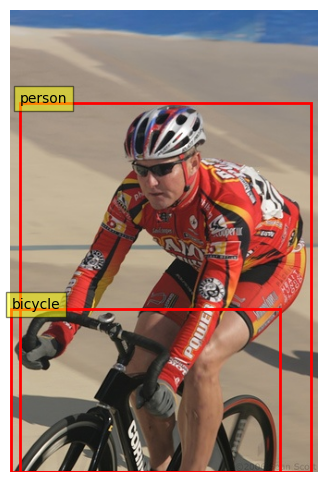

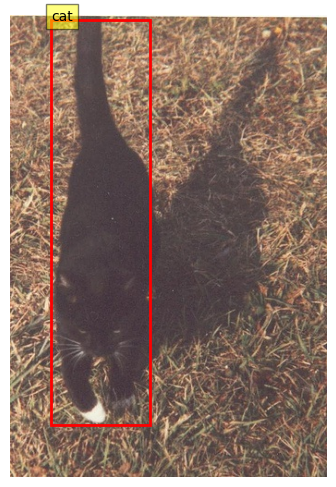

In [ ]:
import random

for i in random.sample(range(len(train_dataset)), 3):
    plot_voc_sample(i)


1.4 Implement Simple Data Augmentation

     

*  Augmentations: For example, random horizontal flip, random crop, or color jitter can be applied.
*   Example with Random Horizontal Flip:



    

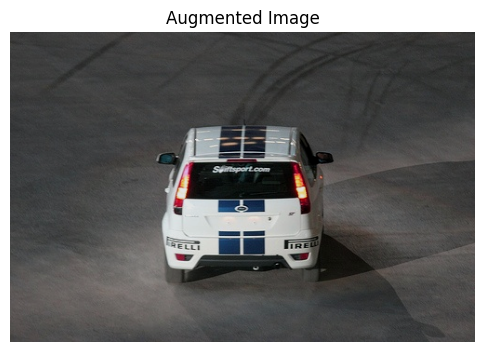

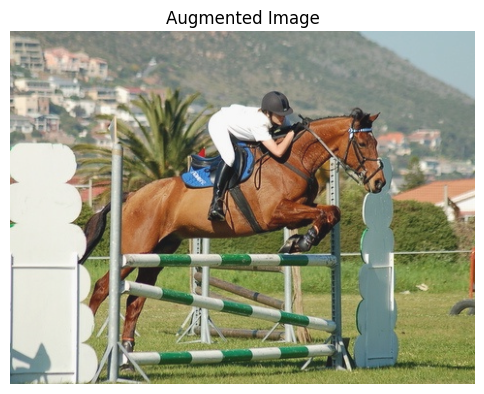

In [ ]:
from torchvision.transforms import RandomHorizontalFlip, ColorJitter

# Create an augmentation transform
aug_transform = T.Compose([
    T.ToTensor(),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Apply augmentation to a sample image and plot results
def plot_augmented_sample(idx, transform_aug):
    img, target = dataset[idx]
    aug_img = transform_aug(img)
    npimg = np.transpose(aug_img.numpy(), (1, 2, 0))
    plt.figure(figsize=(6,6))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()

# Show 2 augmented examples:
plot_augmented_sample(0, aug_transform)
plot_augmented_sample(1, aug_transform)


1.5 Summarize Challenges and Observations

Challenges:

 * Dataset Size: A small dataset might not capture the full variance seen in real-world scenarios.

 * Class Imbalance: Some object classes may be underrepresented.

 * Annotation Quality: Variations in bounding box quality and label accuracy can affect training.

Observations:

 * Data augmentation can help improve model robustness.

 * Visualization is key to ensure that the bounding box annotations are correct before training.



---



# Q2 – Fast RCNN Implementation
2.1 Load a Fast RCNN Model

 * Using PyTorch/Keras: Although Fast RCNN is an older approach, you can mimic its behavior by using a simpler detector or modify existing implementations.

 * Example using a pre-trained detector (illustrative code):

In [ ]:
import torchvision.models as models

# NOTE: PyTorch primarily provides Faster RCNN implementations.
# For Fast RCNN, one might refer to academic code or simplified implementations.
# Here we assume a simplified model instantiation.
fast_rcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(fast_rcnn_model)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 188MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

2.2 Configure the Model for Training

 * Hyperparameters: Set learning rate, batch size, optimizer, etc.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fast_rcnn_model.to(device)

# Example hyperparameters
learning_rate = 0.005
optimizer = torch.optim.SGD(fast_rcnn_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
num_epochs = 10


2.3 Train the Model on the Prepared Dataset

 * Training Loop: Run through epochs, track loss and at least one validation metric (e.g., mAP computed externally).

In [ ]:
import torch

# Optionally, define a mapping from class names to integer labels.
# Here we simply assign 1 to every object as a placeholder.
def convert_voc_target(target):
    ann = target['annotation']
    boxes = []
    labels = []
    # The 'object' key may be a dict if only one object is present, so standardize it to a list:
    objs = ann.get('object', [])
    if not isinstance(objs, list):
        objs = [objs]
    for obj in objs:
        bndbox = obj['bndbox']
        xmin = float(bndbox['xmin'])
        ymin = float(bndbox['ymin'])
        xmax = float(bndbox['xmax'])
        ymax = float(bndbox['ymax'])
        boxes.append([xmin, ymin, xmax, ymax])
        # Replace this with your actual label mapping, e.g., label_map[obj['name']]
        labels.append(1)
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    return {'boxes': boxes, 'labels': labels}


 * Validation: Use a function to compute metrics such as mAP (often available in libraries like COCO API).

2.4 Visualize Predictions

 * Overlay predicted bounding boxes on 3–5 validation images:

In [ ]:
import torchvision.transforms as T

# Define a transform to convert PIL Image to Tensor
to_tensor = T.ToTensor()

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        # Convert each image to a tensor and move it to the device
        images = [to_tensor(img).to(device) for img in images]
        # Process targets (make sure targets are converted appropriately)
        targets = [convert_voc_target(t) for t in targets]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    return epoch_loss

# Then run your training loop:
for epoch in range(num_epochs):
    loss = train_one_epoch(fast_rcnn_model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")


Epoch 1/10, Loss: 161.2708
Epoch 2/10, Loss: 129.4361
Epoch 3/10, Loss: 108.8515
Epoch 4/10, Loss: 94.9389
Epoch 5/10, Loss: 84.0148
Epoch 6/10, Loss: 75.1762
Epoch 7/10, Loss: 69.4851
Epoch 8/10, Loss: 65.4655
Epoch 9/10, Loss: 62.4267
Epoch 10/10, Loss: 59.0151


2.5 Evaluate Performance

**Metrics**:

  * mAP/IoU: Compute these using standard evaluation scripts (e.g., COCO evaluation scripts).

  * Inference Speed: Time per image (use Python’s time module).

 * Memory Usage: Estimate using torch.cuda.max_memory_allocated() if on GPU.

**Discussion**:

 * Strengths: Fast RCNN benefits from end-to-end training with region proposals.

 * Weaknesses: It is slower at inference time than single-stage detectors and may require extra post-processing.



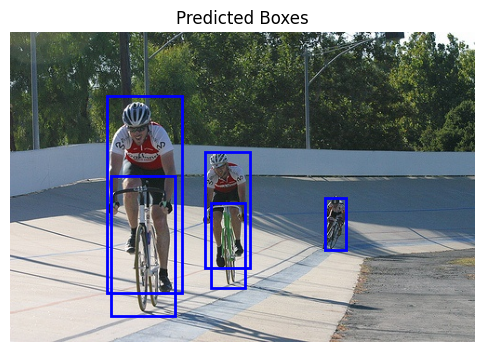

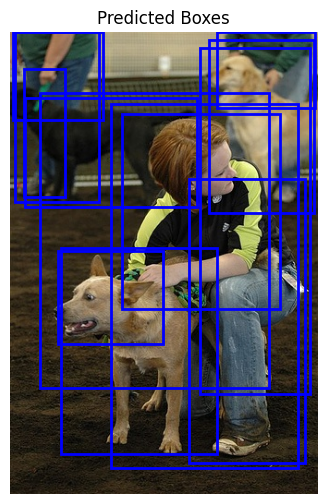

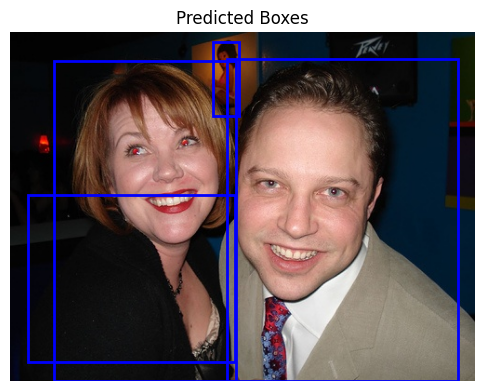

In [ ]:
import torchvision.transforms as T

def plot_predictions(model, data_loader, device, num_images=3):
    model.eval()
    images, targets = next(iter(data_loader))
    # Create a transform to convert PIL image to Tensor.
    to_tensor = T.ToTensor()
    # Convert each image to a tensor and move to the device.
    images = [to_tensor(img).to(device) for img in images]

    with torch.no_grad():
        predictions = model(images)

    for i in range(num_images):
        img_np = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        plt.figure(figsize=(6,6))
        plt.imshow(np.clip(img_np, 0, 1))
        for box in predictions[i]['boxes'].cpu().numpy():
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                               fill=False, edgecolor='blue', linewidth=2))
        plt.title("Predicted Boxes")
        plt.axis('off')
        plt.show()

# Now call the function:
plot_predictions(fast_rcnn_model, val_loader, device)



---

# **Q3 – Faster RCNN Implementation**

3.1 Load a Faster RCNN Model

 * Using PyTorch:

In [ ]:
import torch
import torchvision.models.detection as detection_models

# Define device: use 'cuda' if available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the Faster RCNN model with pretrained weights
faster_rcnn_model = detection_models.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torchvision.transforms as T

# Define a transform to convert PIL Image to Tensor
to_tensor = T.ToTensor()

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        # Convert each image to a tensor and move it to the device
        images = [to_tensor(img).to(device) for img in images]
        # Process targets (make sure targets are converted appropriately)
        targets = [convert_voc_target(t) for t in targets]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    return epoch_loss

3.2 Train the Faster RCNN Model

 * Reuse the same pipeline and training loop as in Q2.

In [ ]:
for epoch in range(num_epochs):
    loss = train_one_epoch(faster_rcnn_model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

Epoch 1/10, Loss: 474.5574
Epoch 2/10, Loss: 474.1050
Epoch 3/10, Loss: 474.4916
Epoch 4/10, Loss: 474.1042
Epoch 5/10, Loss: 474.1951
Epoch 6/10, Loss: 473.8733
Epoch 7/10, Loss: 474.0964
Epoch 8/10, Loss: 473.7434
Epoch 9/10, Loss: 474.4696
Epoch 10/10, Loss: 474.1516


3.3 Validate the Model

 * Compute Metrics: Use the same evaluation routine as Q2 to compute mAP and IoU.

3.4 Visualize Predictions

 * Plot bounding boxes on validation images:

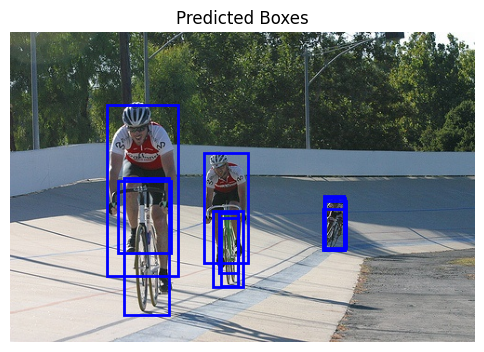

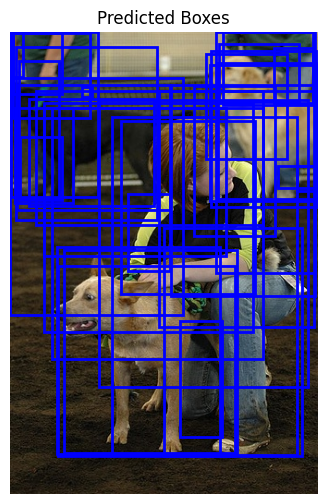

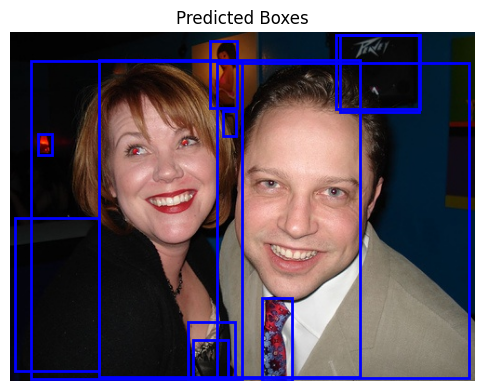

In [ ]:
plot_predictions(faster_rcnn_model, val_loader, device)


3.5 Compare Fast RCNN vs. Faster RCNN


---




# **Q4 – YOLO (Older Version)**

4.1 Load and Train YOLO

 * Using an Established Repo: For instance, clone Ultralytics YOLOv5 (which supports older YOLO versions such as YOLOv3).

In [ ]:
# In a shell cell in your notebook:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt



Cloning into 'yolov5'...
remote: Enumerating objects: 17360, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 17360 (delta 36), reused 18 (delta 18), pack-reused 17308 (from 2)
Receiving objects: 100% (17360/17360), 16.25 MiB | 27.97 MiB/s, done.
Resolving deltas: 100% (11901/11901), done.
/content/yolov5/yolov5


In [ ]:
!python train.py --data data/coco128.yaml --weights yolov5s.pt --project runs/train --name exp2


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-03 03:04:13.854377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743649453.877342   42585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743649453.884328   42585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&

**Q5 – YOLO (Latest Version) + Advanced Extensions**


5.1 Train a Modern YOLO Variant

 * Example using YOLOv8 (Ultralytics):

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 43.9/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model (using the nano version for quick training)
model_old = YOLO('yolov8n.pt')

# Train the model using a dataset configuration (e.g., coco8.yaml)
model_old.train(data='coco8.yaml', epochs=50)
results_old = model_old("/content/bus.jpg")

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train19
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.918G       1.04      2.722       1.29         18        640: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]

                   all          4         17      0.609      0.862      0.888       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.941G      1.252      2.965      1.619         22        640: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

                   all          4         17      0.588      0.884      0.888      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.941G      1.304      2.776      1.567         24        640: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]

                   all          4         17      0.571       0.88      0.888      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.941G      1.043       2.67      1.285         34        640: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]

                   all          4         17      0.549      0.833      0.874      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.941G      1.123      2.984      1.517         24        640: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.88it/s]

                   all          4         17      0.847      0.577      0.874      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.941G      1.021      2.168      1.298         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.57it/s]

                   all          4         17       0.83      0.567      0.872      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.941G      1.504      3.675      1.822         16        640: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.37it/s]

                   all          4         17      0.837       0.58      0.888      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.941G      1.312      3.234      1.752         15        640: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]

                   all          4         17      0.805      0.567      0.886      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.941G      1.497      2.775      1.605         27        640: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]

                   all          4         17      0.809      0.582      0.761      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.941G      1.286      2.527      1.574         22        640: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]

                   all          4         17      0.767      0.583      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.941G      1.211      1.895      1.519         17        640: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.23it/s]

                   all          4         17      0.781      0.583      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.941G      1.347      3.057      1.617         44        640: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          4         17      0.756      0.583      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.941G      1.167      2.651      1.488         33        640: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]

                   all          4         17      0.714      0.583      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.941G      1.069      2.365      1.397         29        640: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]

                   all          4         17      0.703      0.583      0.743      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.941G      1.244      2.716      1.576         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.69it/s]

                   all          4         17      0.728      0.583      0.744      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.941G      1.096      2.527       1.38         36        640: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.08it/s]

                   all          4         17      0.927      0.373      0.744      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.941G     0.9132      2.965      1.355         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.80it/s]

                   all          4         17      0.922      0.373      0.744      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.941G     0.9098      2.863      1.307         18        640: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.57it/s]

                   all          4         17      0.922      0.373      0.744      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.941G      1.045      2.347      1.465         22        640: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]

                   all          4         17      0.912      0.377      0.661      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.941G        1.2      2.781      1.479         15        640: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.51it/s]

                   all          4         17      0.912      0.377      0.661      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.941G      1.194      2.446      1.599         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]

                   all          4         17      0.924      0.373      0.527      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.941G      1.082       2.66      1.486         22        640: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]

                   all          4         17      0.924      0.373      0.527      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.941G     0.9331      2.043      1.456         19        640: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.34it/s]

                   all          4         17      0.916      0.372      0.514      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.941G      0.792      1.791      1.256         25        640: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.24it/s]

                   all          4         17      0.916      0.372      0.514      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.941G     0.7798      1.711      1.188         20        640: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.33it/s]

                   all          4         17      0.918      0.373       0.52      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.941G      1.136      2.214      1.372         47        640: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.67it/s]

                   all          4         17      0.918      0.373       0.52      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.941G      1.037       1.72      1.329         40        640: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]

                   all          4         17      0.925      0.373      0.599      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.941G      1.145      1.471       1.42         24        640: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.55it/s]

                   all          4         17      0.925      0.373      0.599      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.941G      1.225      2.231      1.554         29        640: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.20it/s]

                   all          4         17      0.925      0.373      0.503      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.941G     0.8476      1.984      1.404         17        640: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]

                   all          4         17      0.925      0.373      0.503      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.941G      1.028      2.164      1.394         21        640: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.93it/s]

                   all          4         17      0.921      0.373      0.453      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.941G     0.9902      2.012       1.48         15        640: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.67it/s]

                   all          4         17      0.921      0.373      0.453      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.941G     0.8807      1.208      1.317         23        640: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]

                   all          4         17       0.92      0.374      0.449      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.941G      1.114      1.848      1.336         26        640: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]

                   all          4         17       0.92      0.374      0.449      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.953G     0.7299      1.294      1.101         36        640: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]

                   all          4         17      0.921      0.374      0.441      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.961G     0.7111      1.924      1.221         31        640: 100%|██████████| 1/1 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]

                   all          4         17      0.921      0.374      0.441      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.973G       1.06      1.772      1.485         19        640: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.44it/s]

                   all          4         17      0.922      0.376       0.41      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.973G      1.001      1.571      1.216         49        640: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]

                   all          4         17      0.922      0.376       0.41      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.973G     0.6085      1.231     0.9864         32        640: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.50it/s]

                   all          4         17      0.921      0.376      0.411      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      0.98G      1.006      1.896       1.43         14        640: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.65it/s]

                   all          4         17      0.921      0.376      0.411      0.258


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.988G     0.8006      1.062      1.125         13        640: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

                   all          4         17      0.926      0.377      0.411      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.988G     0.6856      0.959      1.169         13        640: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]

                   all          4         17      0.926      0.377      0.411      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.988G     0.7544      1.134      1.063         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         17      0.927      0.376      0.408      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.996G     0.7539     0.7613      1.071         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]

                   all          4         17      0.927      0.376      0.408      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.03G     0.6961      1.295      1.141         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.20it/s]

                   all          4         17      0.928      0.378       0.41      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.03G     0.6437     0.8508      1.013         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.74it/s]

                   all          4         17      0.928      0.378       0.41      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.03G     0.6983      1.072      1.151         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.44it/s]

                   all          4         17      0.929      0.383      0.411      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.03G     0.6357     0.9198      1.054         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.40it/s]

                   all          4         17      0.929      0.383      0.411      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.04G     0.7514      1.087       1.25         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.48it/s]

                   all          4         17      0.927      0.383      0.411      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.05G     0.7399      1.052      1.191         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]

                   all          4         17      0.927      0.383      0.411      0.278



50 epochs completed in 0.007 hours.
Optimizer stripped from runs/detect/train19/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train19/weights/best.pt, 6.5MB

Validating runs/detect/train19/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.26it/s]


                   all          4         17       0.61      0.859      0.888      0.622
                person          3         10      0.675        0.5       0.52      0.283
                   dog          1          1      0.345          1      0.995      0.597
                 horse          1          2      0.739          1      0.995      0.631
              elephant          1          2      0.552      0.657      0.828      0.332
              umbrella          1          1      0.555          1      0.995      0.995
          potted plant          1          1      0.795          1      0.995      0.895
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train19

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 10.8ms
Speed: 4.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo12n.pt")

# Train the model on the COCO8 example dataset for 100 epochs
model.train(data="coco8.yaml", epochs=100, imgsz=640)

# Run inference with the YOLO12n model on the 'bus.jpg' image
results_new = model("/content/bus.jpg")

Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /content/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/detect/train20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train20
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.2G     0.8312       1.71      1.228         18        640: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]

                   all          4         17     0.0233      0.217     0.0897     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       1.2G     0.9818      2.416      1.414         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]

                   all          4         17     0.0575      0.317      0.127      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       1.2G      1.383      2.056       1.67         24        640: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

                   all          4         17     0.0735      0.567       0.14     0.0598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.2G     0.9785       1.61      1.346         34        640: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]

                   all          4         17     0.0653      0.567       0.14     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.2G      1.137      1.997      1.573         24        640: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

                   all          4         17     0.0582      0.567      0.245       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       1.2G     0.8388      1.528      1.262         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         17      0.392      0.283      0.263      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       1.2G     0.9455      2.732      1.382         16        640: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]

                   all          4         17      0.562      0.267      0.268      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.2G      1.078      3.121      1.652         15        640: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]

                   all          4         17      0.642      0.267      0.281      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       1.2G      1.247       1.79      1.554         27        640: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]

                   all          4         17       0.55      0.367      0.303      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.2G       1.01      1.567      1.461         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]

                   all          4         17      0.611       0.34      0.364      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       1.2G     0.9771       1.26      1.375         17        640: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

                   all          4         17      0.638      0.364      0.392      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       1.2G      1.055      1.979      1.319         44        640: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]

                   all          4         17      0.714      0.361      0.436        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       1.2G     0.9511       1.61      1.254         33        640: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]

                   all          4         17       0.72      0.357      0.495      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.21G      1.024      1.264      1.396         29        640: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]

                   all          4         17      0.719      0.357      0.508      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.22G     0.9685      1.635      1.401         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

                   all          4         17      0.637        0.4      0.524      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.24G      1.019      1.138      1.396         36        640: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]

                   all          4         17       0.67      0.409      0.575       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.24G      0.968      1.738      1.395         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]

                   all          4         17       0.67      0.428      0.576      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.25G     0.7987       1.17      1.169         18        640: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]

                   all          4         17       0.67      0.428      0.576      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.28G     0.9019      1.169      1.416         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]

                   all          4         17      0.686      0.415      0.636       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.28G      1.167      1.463      1.512         15        640: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]

                   all          4         17      0.686      0.415      0.636       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.28G      0.896      1.131      1.372         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

                   all          4         17      0.798      0.356      0.695      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.28G     0.8683      1.291      1.313         22        640: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

                   all          4         17      0.798      0.356      0.695      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.28G     0.8681      1.035      1.398         19        640: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]

                   all          4         17      0.801      0.351      0.781      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.28G     0.5424     0.8052       1.08         25        640: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


                   all          4         17      0.801      0.351      0.781      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.28G     0.6822     0.9005      1.082         20        640: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

                   all          4         17      0.684       0.45      0.757      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.28G     0.9319     0.9824      1.216         47        640: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]

                   all          4         17      0.684       0.45      0.757      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.28G     0.9191     0.9802      1.279         40        640: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

                   all          4         17      0.851      0.438      0.786      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.28G     0.9773     0.9491      1.264         24        640: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

                   all          4         17      0.851      0.438      0.786      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.28G     0.8294     0.9428      1.309         29        640: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

                   all          4         17      0.974       0.36       0.85      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.28G     0.6181      0.563      1.414         17        640: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

                   all          4         17      0.974       0.36       0.85      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.28G     0.7928     0.8668      1.198         21        640: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

                   all          4         17      0.736      0.467      0.847       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.28G     0.7214      1.085      1.217         15        640: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

                   all          4         17      0.736      0.467      0.847       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.28G     0.7405      0.636      1.168         23        640: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]

                   all          4         17      0.726      0.467      0.892      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.28G      1.058     0.7996      1.268         26        640: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

                   all          4         17      0.726      0.467      0.892      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.28G     0.6201     0.6357      1.039         36        640: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

                   all          4         17        0.7      0.633      0.889      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.28G     0.6192     0.7978      1.139         31        640: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

                   all          4         17        0.7      0.633      0.889      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.28G      1.013      0.862       1.56         19        640: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]

                   all          4         17      0.705      0.633       0.86      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.28G     0.7425     0.7006      1.088         49        640: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

                   all          4         17      0.705      0.633       0.86      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.28G     0.5651      0.563     0.9709         32        640: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

                   all          4         17        0.7      0.633      0.863      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.28G     0.7513     0.5894      1.212         14        640: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]

                   all          4         17        0.7      0.633      0.863      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.28G     0.6794     0.5688      1.094         39        640: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]

                   all          4         17      0.685      0.617      0.859      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.28G     0.7724     0.6132      1.128         46        640: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]

                   all          4         17      0.685      0.617      0.859      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.28G      0.558     0.5261      1.132         17        640: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]

                   all          4         17      0.695      0.617      0.886      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.28G     0.8872        1.2      1.256         47        640: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

                   all          4         17      0.695      0.617      0.886      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.28G     0.6351     0.6048      1.168         32        640: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]

                   all          4         17      0.688      0.617      0.872      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.28G      0.827     0.8825        1.2         17        640: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]

                   all          4         17      0.688      0.617      0.872      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.28G     0.7755     0.6597       1.15         18        640: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]

                   all          4         17      0.749      0.598      0.882      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.28G     0.7082     0.4752      1.195         20        640: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]

                   all          4         17      0.749      0.598      0.882      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.28G     0.6486     0.6357      1.073         23        640: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]

                   all          4         17      0.735      0.593      0.865       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.28G     0.6838      0.591      1.137         34        640: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

                   all          4         17      0.735      0.593      0.865       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.28G     0.8075     0.6049      1.149         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]

                   all          4         17      0.725      0.592      0.857      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.28G     0.6581       0.74      1.055         41        640: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

                   all          4         17      0.725      0.592      0.857      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.28G     0.6029     0.4881       1.02         22        640: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

                   all          4         17      0.725      0.592      0.857      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.28G     0.5926     0.4888      1.173         19        640: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]

                   all          4         17      0.715      0.583      0.866      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.28G     0.5405     0.7117      1.017         38        640: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

                   all          4         17      0.715      0.583      0.866      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.28G     0.7131     0.5437      1.236         16        640: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

                   all          4         17      0.715      0.583      0.866      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.28G     0.6339     0.5034      1.058         26        640: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]

                   all          4         17      0.716      0.583      0.866      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.28G     0.5453     0.6221      1.098         19        640: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         17      0.716      0.583      0.866      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.28G     0.7714     0.4836      1.071         27        640: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


                   all          4         17      0.716      0.583      0.866      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.28G     0.7479     0.6685      1.122         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]

                   all          4         17      0.706      0.583       0.78      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.28G     0.5568     0.5124     0.9465         30        640: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

                   all          4         17      0.706      0.583       0.78      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.28G      0.436     0.4304     0.9284         25        640: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

                   all          4         17      0.706      0.583       0.78      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.28G     0.7141     0.7636      1.197         26        640: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]

                   all          4         17      0.684      0.583       0.78      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.28G     0.6232     0.4688      1.157         20        640: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

                   all          4         17      0.684      0.583       0.78      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.28G     0.5154     0.3831      1.005         19        640: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

                   all          4         17      0.684      0.583       0.78      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.28G     0.5388     0.7166      1.011         41        640: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

                   all          4         17      0.674      0.583       0.78       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.28G     0.6464     0.7357      1.126         36        640: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

                   all          4         17      0.674      0.583       0.78       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.28G     0.6837      0.545      1.106         39        640: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

                   all          4         17      0.674      0.583       0.78       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.28G     0.6379     0.4704      1.062         28        640: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]

                   all          4         17      0.686      0.593       0.78      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.28G     0.4336      0.395     0.9343         19        640: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

                   all          4         17      0.686      0.593       0.78      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.28G     0.5304     0.4091      1.012         34        640: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]

                   all          4         17      0.686      0.593       0.78      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.28G     0.4073     0.3246      1.018         19        640: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]

                   all          4         17      0.695      0.584      0.735      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.28G     0.6321     0.4586      1.084         30        640: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

                   all          4         17      0.695      0.584      0.735      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.28G     0.5272     0.4291       1.08         23        640: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]

                   all          4         17      0.695      0.584      0.735      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.28G     0.5769     0.5116      1.008         22        640: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

                   all          4         17      0.721      0.583      0.734      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.28G     0.5058     0.4495     0.9758         31        640: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]

                   all          4         17      0.721      0.583      0.734      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.28G     0.6437     0.5433      1.067         24        640: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

                   all          4         17      0.721      0.583      0.734      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.28G     0.7506     0.5072      1.212         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]

                   all          4         17      0.735      0.583      0.762      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.28G     0.5446     0.5542      1.063         34        640: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

                   all          4         17      0.735      0.583      0.762      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.28G     0.5577     0.4783      0.988         31        640: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


                   all          4         17      0.735      0.583      0.762      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.28G     0.6457     0.6777      1.088         13        640: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

                   all          4         17      0.728      0.577      0.759      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.28G     0.5815     0.4698      1.117         19        640: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

                   all          4         17      0.728      0.577      0.759      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.28G     0.6204     0.6117      1.188         18        640: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]

                   all          4         17      0.728      0.577      0.759      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.28G     0.6404     0.5496      1.067         33        640: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]

                   all          4         17      0.663      0.583       0.84      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.28G       0.79      1.222      1.274         51        640: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]

                   all          4         17      0.663      0.583       0.84      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.28G      0.636     0.7111      1.077         47        640: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]

                   all          4         17      0.663      0.583       0.84      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.28G     0.9517     0.9259      1.431         22        640: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


                   all          4         17      0.663      0.583       0.84      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.28G     0.4851     0.5876     0.9962         38        640: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

                   all          4         17      0.639        0.6      0.666      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.28G     0.4262      0.679      1.099         15        640: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]

                   all          4         17      0.639        0.6      0.666      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.28G      0.743     0.5533      1.183         21        640: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


                   all          4         17      0.639        0.6      0.666      0.445
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.28G     0.4335     0.3792     0.8972         13        640: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]

                   all          4         17      0.639        0.6      0.666      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.28G     0.4661     0.3467     0.8263         13        640: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]

                   all          4         17      0.643      0.583      0.839      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.28G     0.4463     0.3533      0.883         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

                   all          4         17      0.643      0.583      0.839      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.28G      0.421     0.3479     0.9296         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

                   all          4         17      0.643      0.583      0.839      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.28G     0.4878     0.3826     0.9309         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

                   all          4         17      0.643      0.583      0.839      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.28G     0.5468     0.4561      1.063         13        640: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

                   all          4         17      0.646      0.583      0.821      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.28G     0.4425     0.3885     0.8974         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]

                   all          4         17      0.646      0.583      0.821      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.28G     0.4288     0.3036       1.02         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

                   all          4         17      0.646      0.583      0.821      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.28G     0.3646     0.3305     0.9056         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


                   all          4         17      0.646      0.583      0.821      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.28G     0.3579      0.324     0.8735         13        640: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

                   all          4         17      0.674      0.567      0.917      0.594



100 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train20/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train20/weights/best.pt, 5.6MB

Validating runs/detect/train20/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12n summary (fused): 159 layers, 2,590,824 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.10it/s]


                   all          4         17      0.716      0.583      0.857      0.605
                person          3         10      0.569        0.5      0.635      0.289
                   dog          1          1      0.714          1      0.995      0.796
                 horse          1          2      0.468          1      0.828      0.514
              elephant          1          2          1          0      0.695      0.139
              umbrella          1          1      0.544          1      0.995      0.995
          potted plant          1          1          1          0      0.995      0.895
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train20

image 1/1 /content/bus.jpg: 640x480 3 persons, 1 bus, 16.5ms
Speed: 3.5ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


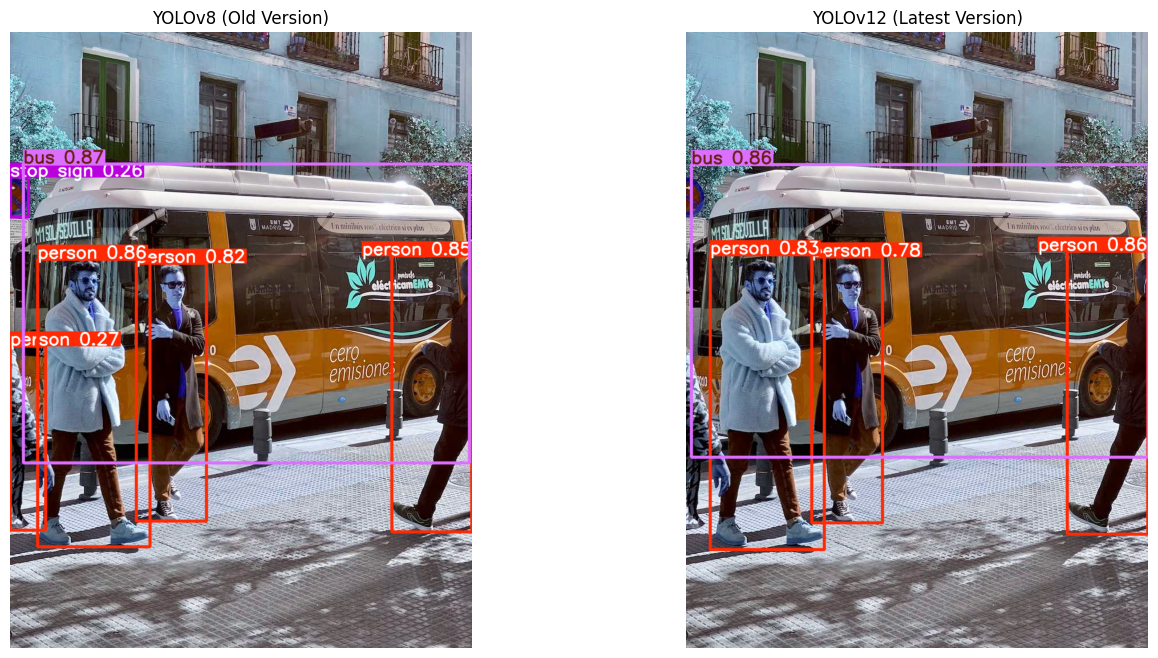

In [ ]:
# Extract annotated images
new_image = results_new[0].plot()  # YOLOv12 result
old_image = results_old[0].plot()  # YOLOv8 result

# Display the results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(old_image)
axes[0].set_title("YOLOv8 (Old Version)")
axes[0].axis("off")

axes[1].imshow(new_image)
axes[1].set_title("YOLOv12 (Latest Version)")
axes[1].axis("off")

plt.show()

In [ ]:
results_old = model_old("/content/pathalogy.jpg")
results_new = model("/content/pathalogy.jpg")


image 1/1 /content/pathalogy.jpg: 448x640 2 persons, 2 bottles, 1 cup, 1 laptop, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/pathalogy.jpg: 448x640 2 persons, 2 bottles, 1 cup, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


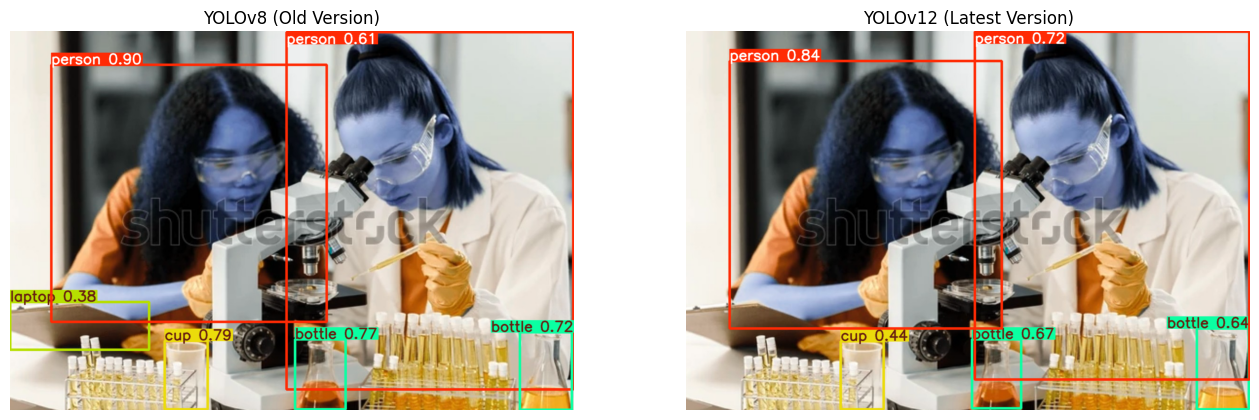

In [ ]:
# Extract annotated images
new_image = results_new[0].plot()  # YOLOv12 result
old_image = results_old[0].plot()  # YOLOv8 result

# Display the results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(old_image)
axes[0].set_title("YOLOv8 (Old Version)")
axes[0].axis("off")

axes[1].imshow(new_image)
axes[1].set_title("YOLOv12 (Latest Version)")
axes[1].axis("off")

plt.show()

In [ ]:
results_old = model_old("/content/CUTE ANIMALS.png")
results_new = model("/content/CUTE ANIMALS.png")


image 1/1 /content/CUTE ANIMALS.png: 640x448 1 dog, 4 teddy bears, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/CUTE ANIMALS.png: 640x448 (no detections), 16.1ms
Speed: 2.7ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


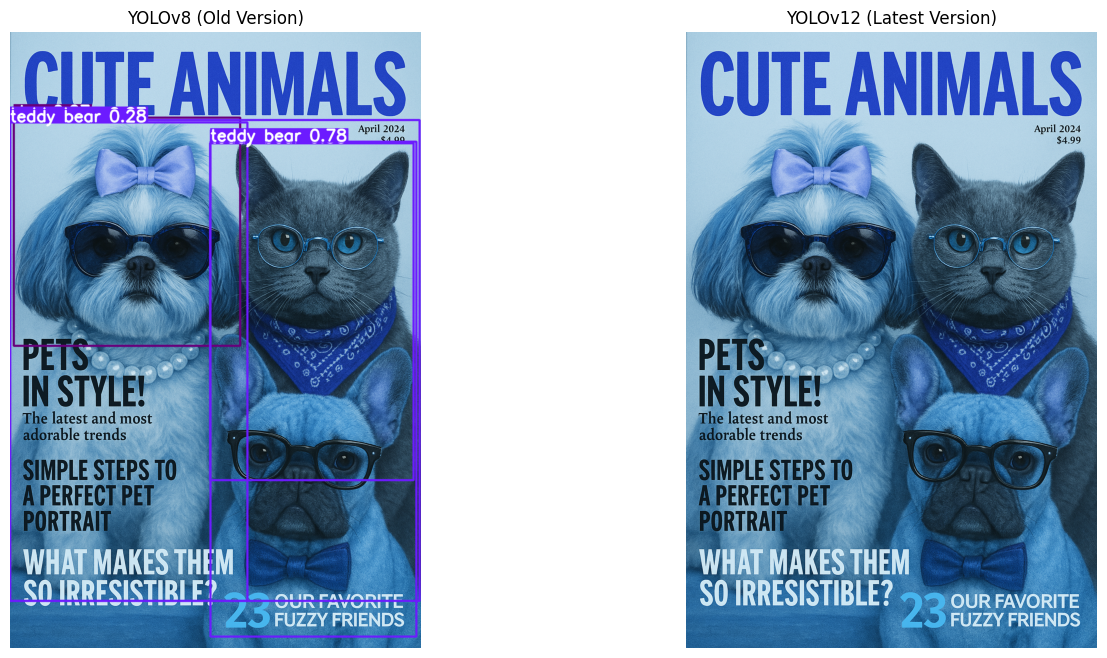

In [ ]:
# Extract annotated images
new_image = results_new[0].plot()  # YOLOv12 result
old_image = results_old[0].plot()  # YOLOv8 result

# Display the results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(old_image)
axes[0].set_title("YOLOv8 (Old Version)")
axes[0].axis("off")

axes[1].imshow(new_image)
axes[1].set_title("YOLOv12 (Latest Version)")
axes[1].axis("off")

plt.show()